# Assignment 1

## Import Libraries


We will import Relevant libraries which will be use for our porject.

In [103]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import copy
import math
import os
import numpy as np
from tqdm import tqdm
import torch.nn as nn
from pathlib import Path
from PIL import Image
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import confusion_matrix 
from sklearn.metrics import classification_report
from sklearn import model_selection
from torch import nn
from torch import optim
from torchtext.legacy import data
from torch.utils.data import DataLoader
from wordcloud import WordCloud
import nltk
import re

%matplotlib inline
sns.set_style('whitegrid')

In [2]:
# for ignoring warnings
import warnings
warnings.filterwarnings("ignore")
import random
SEED = 1962
torch.manual_seed(SEED)

## Checking Device
Set the Device to GPU or CPU.

In [3]:
# Check If the a GPU is available
if torch.cuda.is_available():    
    # Tell PyTorch to use the GPU.    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('We will use the GPU:', torch.cuda.get_device_name(0))
else:
    print('GPU is not available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: NVIDIA GeForce RTX 2060 with Max-Q Design


# Steps:
## 1. Data loading and Pre_Processing

##### Read Dataset

In [4]:
reviews = pd.read_csv("data/imdb_dataset.csv")

##### Dimensions of Data

In [5]:
reviews.shape

(48000, 2)

##### Peak at the Data

In [6]:
reviews.head()

review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive

In [7]:
reviews.tail()

review sentiment
47995  First of all, Blythe Danner doesn't look anywh...  negative
47996  I wouldn't be so quick to look at all the good...  negative
47997  Everything about this show is terrible. Its pr...  negative
47998  This movie just was not very funny. There's no...  negative
47999  "The Yoke's on Me" is undoubtedly the most con...  negative

##### Attributes in Data

In [8]:
reviews.columns

Index(['review', 'sentiment'], dtype='object')

##### Describe the Data

In [9]:
reviews.describe()

review sentiment
count                                               48000     48000
unique                                              47622         2
top     Loved today's show!!! It was a variety and not...  positive
freq                                                    5     24000

It means there are some Duplicate Records in the data. 

Let's use groupby to use describe by label, this way we can begin to think about the features that separate Pos and Neg!

In [13]:
reviews.groupby('sentiment').describe()

review                                                            \
           count unique                                                top   
sentiment                                                                    
negative   24000  23724  This show comes up with interesting locations ...   
positive   24000  23898  Loved today's show!!! It was a variety and not...   

                
          freq  
sentiment       
negative     3  
positive     5

### Text Pre-processing

##### Check Null Values

In [14]:
reviews.isnull().sum()

review       0
sentiment    0
dtype: int64

##### Check Duplicate Recode

In [15]:
reviews.review.duplicated().sum()

378

In [16]:
reviews.drop_duplicates(subset=['review'],keep='first',inplace=True) # drop duplicates and kepp one of them

##### Clean Text
Let's create a function that will process the string in the review column, then we can just use apply() in pandas do process all the text in the DataFrame.

In [19]:
stopwords = set(nltk.corpus.stopwords.words('english'))
english_words = set(nltk.corpus.words.words())

In [20]:
def preprocess(text, english_words):
    
    text = text.lower()
    html_tag = '<.*?>'
    text = re.sub(html_tag, '', text)
    # Removing Punctuation marks
    tokenizer = nltk.RegexpTokenizer(r"\w+")
    rem_punc = tokenizer.tokenize(text)
    # Removing Stop Words
    rem_stop_words = [word for word in rem_punc if not word in stopwords]
    english_words = [word for word in rem_stop_words if word in english_words]
    sentence = ' '.join(english_words)
    
    return sentence

In [21]:
reviews['review'][3]

"Basically there's a family where a little boy (Jake) thinks there's a zombie in his closet & his parents are fighting all the time.<br /><br />This movie is slower than a soap opera... and suddenly, Jake decides to become Rambo and kill the zombie.<br /><br />OK, first of all when you're going to make a film you must Decide if its a thriller or a drama! As a drama the movie is watchable. Parents are divorcing & arguing like in real life. And then we have Jake with his closet which totally ruins all the film! I expected to see a BOOGEYMAN similar movie, and instead i watched a drama with some meaningless thriller spots.<br /><br />3 out of 10 just for the well playing parents & descent dialogs. As for the shots with Jake: just ignore them."

In [24]:
reviews['review'] = reviews['review'].apply(lambda x : preprocess(x, english_words))

In [25]:
reviews['review'][3]

'basically family little boy jake zombie closet fighting time movie soap opera suddenly jake become kill zombie first going make film must decide thriller drama drama movie watchable like real life jake closet totally film see similar movie instead watched drama meaningless thriller well descent jake ignore'

#### Label Encoidng

In [26]:
reviews['sentiment']= reviews['sentiment'].map( {'positive':1, 'negative': 0} ).astype(int)

### Exploratory Data Analysis

Let's make a new column to detect how long the text messages are:

In [27]:
reviews['length'] = reviews['review'].str.len() #check Leanth of Each tweet
reviews.head()

review  sentiment  length
0  one watching episode hooked right exactly firs...          1     757
1  wonderful little production technique unassumi...          1     458
2  thought wonderful way spend time hot summer we...          1     470
3  basically family little boy jake zombie closet...          0     307
4  petter love time money visually stunning film ...          1     620

In [29]:
reviews.length.describe()

count    47622.000000
mean       607.156377
std        461.739841
min         17.000000
25%        323.000000
50%        451.000000
75%        739.000000
max       6378.000000
Name: length, dtype: float64

Maximum tweet leanth is 6378, which is very long and as we see mean is 607. We will remove long tweets. We will remove top 100 indexes with maximum length.

In [31]:
reviews = reviews.sample(frac=1,random_state=SEED).reset_index(drop=True) #shuffle data frame

### Data Visualization

<AxesSubplot:xlabel='length', ylabel='Density'>

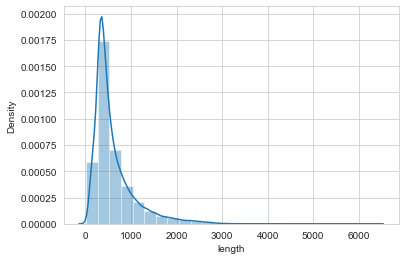

In [32]:
sns.set_style('whitegrid')
sns.distplot(reviews['length'],bins=25)

Most of the reviews are between 0 to 1000 lengths. Now we will remove top 100 indexes with maximum length.

In [36]:
np.sort(-reviews['length'])[0:100]

array([-6378, -6343, -5785, -5586, -4786, -4641, -4560, -4205, -4154,
       -4140, -4099, -4006, -3784, -3720, -3677, -3546, -3541, -3447,
       -3440, -3324, -3292, -3235, -3205, -3195, -3188, -3182, -3164,
       -3159, -3116, -3047, -3043, -3042, -3037, -3032, -3021, -3020,
       -3015, -3012, -3005, -2999, -2997, -2997, -2993, -2987, -2987,
       -2977, -2975, -2962, -2957, -2944, -2937, -2932, -2932, -2929,
       -2928, -2922, -2911, -2907, -2896, -2884, -2879, -2878, -2877,
       -2877, -2874, -2871, -2868, -2868, -2867, -2867, -2861, -2859,
       -2852, -2850, -2850, -2850, -2848, -2843, -2843, -2841, -2841,
       -2840, -2839, -2838, -2835, -2832, -2832, -2831, -2829, -2828,
       -2819, -2819, -2814, -2814, -2812, -2812, -2810, -2804, -2801,
       -2799], dtype=int64)

In [37]:
reviews.drop(reviews.index[np.argsort(-reviews['length'])[0:100]],axis=0,inplace=True)

In [38]:
reviews.length.describe()

count    47522.000000
mean       601.662472
std        445.201237
min         17.000000
25%        322.000000
50%        450.000000
75%        736.000000
max       2797.000000
Name: length, dtype: float64

array([<AxesSubplot:title={'center':'0'}>,
       <AxesSubplot:title={'center':'1'}>], dtype=object)

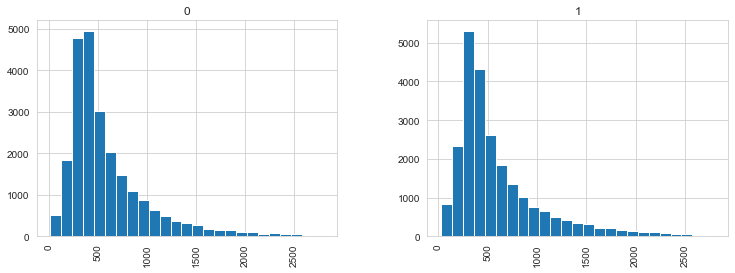

In [39]:
reviews.hist(column='length', by='sentiment', bins=25,figsize=(12,4))

<AxesSubplot:xlabel='sentiment', ylabel='count'>

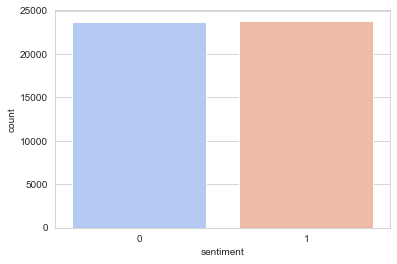

In [40]:
sns.countplot(x='sentiment',data=reviews,palette='coolwarm')

#### Save the clean data

In [41]:
reviews = reviews.sample(frac=1,random_state=SEED).reset_index(drop=True) #shuffle data frame
reviews.to_csv('data/clean.csv',index = False)

### TorchText
We will use the torchtext for loading the data and also do encoding with torchtext.

##### Load the dataset
We will load the dataset and create a vocab and resturn dataloader.

In [207]:
def loadDataset(fix_length, batch_size,embedding_vector = '100'):
    
    # define the columns
    TEXT = data.Field(tokenize = 'spacy',
                  tokenizer_language = 'en_core_web_sm',
                  include_lengths = True,
                  init_token='<start>',
                  eos_token='<end>',
                 fix_length = fix_length)
    
    LABEL = data.LabelField(dtype = torch.long)
    
    # create tuples representing the columns
    fields = [
      ('review', TEXT),
      ('sentiment',LABEL)
    ]
    
    #### Create the Dataset
    dataset, test_dataset = data.TabularDataset.splits(
                                                       path='data',
                                                       train = 'clean.csv',
                                                       test = 'clean_unlabel.csv',
                                                       format = 'csv',
                                                       fields = fields,
                                                       skip_header = True,
                                                    )
    
    ## Split the data
    train_data, test_data = dataset.split(split_ratio=0.7, random_state = random.seed(SEED))
    train_data, valid_data = train_data.split(split_ratio=0.8, random_state = random.seed(SEED))
    print(f'Number of training examples: {len(train_data)}')
    print(f'Number of validation examples: {len(valid_data)}')
    print(f'Number of testing examples: {len(test_data)}')
    
    ### create Vocab
    MAX_VOCAB_SIZE = 30_000
    if embedding_vector == '300':
        
        TEXT.build_vocab(train_data, 
                         max_size = MAX_VOCAB_SIZE, 
                         vectors = "glove.6B.300d", 
                         unk_init = torch.Tensor.normal_)
        LABEL.build_vocab(train_data)
    else:
        TEXT.build_vocab(train_data, 
                         max_size = MAX_VOCAB_SIZE, 
                         vectors = "glove.6B.100d", 
                         unk_init = torch.Tensor.normal_)
        LABEL.build_vocab(train_data)
        
    ### create the Dataloader
    train_iterator, valid_iterator, test_iterator = data.BucketIterator.splits(
                                                                                (train_data, valid_data, test_data), 
                                                                                batch_size = batch_size,
                                                                                sort_key = lambda x: x.review,
                                                                                sort_within_batch = True,
                                                                                device = device)
    
    return train_iterator, valid_iterator, test_iterator, TEXT, test_dataset

## 2. Initialize Network

#### Vanilla RNN Architecture

In [11]:
class RNN(nn.Module):
    
    def __init__(self,input_dim, hidden_dim):

        super().__init__()

        self.input_dim  = input_dim
        self.hidden_dim = hidden_dim
        
        self.W_x = nn.Linear(self.input_dim,self.hidden_dim) 
        self.W_h = nn.Linear(self.hidden_dim,self.hidden_dim) 


    def rnn_single_step(self, inp, prev_h):
        
        h_t = torch.tanh(self.W_x(inp) + self.W_h(prev_h))

        return h_t


    def forward(self, inputs):
        
        seq_dim, batch_size , input_dim = inputs.shape
        
        hidden = torch.zeros((batch_size, self.hidden_dim)).to(device)
        
        outputs = []
        # Loop through the whole sequence and update hideen state at every time step
        for x in inputs:
            hidden = self.rnn_single_step(x , hidden)
            outputs.append(hidden)
        
        return hidden, torch.stack(outputs)

#### LSTM Architecture

In [12]:
class LSTM(nn.Module):
    
    def __init__(self,input_dim, hidden_dim):

        super().__init__()

        self.input_dim  = input_dim
        self.hidden_dim = hidden_dim
                
        self.W_x = nn.Linear(self.input_dim,4 * self.hidden_dim)
        self.W_h = nn.Linear(self.hidden_dim,4 *self.hidden_dim)


    def lstm_step(self, inp, prev_hidden_cell):
        
        h_prev , c_prev = prev_hidden_cell
        
        activation = self.W_x(inp) + self.W_h(h_prev)
                
        # The activation is split into four parts
        ai, af, ac, ao = activation.chunk(4, 1)
        
        updated_h, updated_c = None, None
    
        in_gate     = torch.sigmoid(ai)
        forget_gate = torch.sigmoid(af)
        cell_gate   = torch.sigmoid(ao)
        out_gate    = torch.tanh(ac)

        updated_c  = forget_gate * c_prev + in_gate * out_gate
        updated_h  = cell_gate * torch.tanh(updated_c)

        return updated_h, updated_c


    def forward(self, inp):
        
        # input shape (seq_dim, batch_size, input_dim)
        seq_dim,batch_size , _ = inp.shape

        # Initialize hidden state with zeros (batch_size, hidden_dim)
        h = torch.zeros((batch_size, self.hidden_dim)).to(device) 
        
        # Initialize cell state with zeros (batch_size, hidden_dim)
        c = torch.zeros((batch_size, self.hidden_dim)).to(device)
        outputs = []
        # Loop through the whole sequence and update h_t and c_t at every time step
        for x in inp:
           # shape of x is (batch_size, input_dim )
           h, c = self.lstm_step( x, (h, c))
           outputs.append(h)
        
        return h, torch.stack(outputs)

#### GRU Architecture

In [13]:
class GRU(nn.Module):
    
    def __init__(self,input_dim, hidden_dim):

        super().__init__()

        self.input_dim  = input_dim
        self.hidden_dim = hidden_dim
                
        self.W_x = nn.Linear(self.input_dim,2 * self.hidden_dim)
        self.U_h = nn.Linear(self.hidden_dim,2 *self.hidden_dim)
        
        self.W = nn.Linear(self.input_dim,self.hidden_dim)
        self.U = nn.Linear(self.hidden_dim,self.hidden_dim)


    def GRU_step(self, inp, h_prev):
        
        
        activation = self.W_x(inp) + self.U_h(h_prev)
                
        # The activation is split into 2 parts
        au, ar = activation.chunk(2, 1)
        
        h_t_temp, h_t = None, None
        
        z_t     = torch.sigmoid(au)
        r_t    = torch.sigmoid(ar)

        h_t_temp = torch.tanh(self.W(inp)+(r_t*self.U(h_prev)))
        h_t = (z_t*h_prev) + ((1-z_t)*h_t_temp)

        return h_t


    def forward(self, inp):
        
        # input shape (seq_dim, batch_size, input_dim)
        seq_dim,batch_size , _ = inp.shape

        # Initialize hidden state with zeros (batch_size, hidden_dim)
        hidden = torch.zeros((batch_size, self.hidden_dim)).to(device) 
        
        outputs = []
        # Loop through the whole sequence and update h_t and c_t at every time step
        for x in inp:
            
            hidden = self.GRU_step( x, hidden)
            outputs.append(hidden)
        
        return hidden, torch.stack(outputs)

#### Init_Network

In [14]:
class Initialize_Network(nn.Module):
    
    def __init__(self,type_of_rnn, input_dim,embedding_dim, hidden_dim_per_layer, output_dim, pad_idx, dropout = 0.25):
        
        super(Initialize_Network, self).__init__()
        
        self.embedding = nn.Embedding(input_dim, embedding_dim, padding_idx = pad_idx)
        
        
        # Initialize rnn model
        self.rnn = nn.ModuleList()
        hidden_dim_per_layer.insert(0,embedding_dim)
        if type_of_rnn == "Vanilla RNN":
            for input_size, output_size in zip(hidden_dim_per_layer, hidden_dim_per_layer[1:]):
                self.rnn.append(RNN(input_size, output_size))
        elif type_of_rnn == "GRU":
            for input_size, output_size in zip(hidden_dim_per_layer, hidden_dim_per_layer[1:]):
                self.rnn.append(GRU(input_size, output_size))
        else:
            for input_size, output_size in zip(hidden_dim_per_layer, hidden_dim_per_layer[1:]):
                self.rnn.append(LSTM(input_size, output_size))
        
        self.drop_layer = nn.Dropout(p=dropout)
        # Initialize FC layer
        self.fc = nn.Linear(hidden_dim_per_layer[-1], output_dim)                                    
        
    def forward(self, x):
        
        embeddeding = self.embedding(x)
        
        outputs = embeddeding
        L = len(self.rnn)
        for (l, rnn) in zip(range(L), self.rnn):
            hidden, outputs = rnn(outputs)
            
        hidden = self.drop_layer(hidden.squeeze(0))         
        output = self.fc(hidden)
        
        return output

## 3. Training and Save Best Model

#### 3.1 Plot Graph

In [15]:
# this function will plot the accuracy and loss graph of training and validation
def plot_loss_and_accuracy_curves(history):
    fig, ax = plt.subplots(1, 2, figsize=(20, 5))

    ax[0].plot(history['train_accuracy'], color='royalblue', label='Train Accuracy')
    ax[0].plot(history['val_accuracy'], color='darkred', label='Validation Accuracy')

    ax[0].set_xlabel('Epochs')
    ax[0].set_ylabel('Accuracy')
    ax[0].set_title('Training and Validation Accuracy')
    ax[0].legend()

    ax[1].plot(history['train_loss'], color='royalblue', label='Train Loss')
    ax[1].plot(history['val_loss'], color='darkred', label='Validation Loss')

    ax[1].set_xlabel('Epochs')
    ax[1].set_ylabel('Cross Entropy Loss')
    ax[1].set_title('Training and Validation Losses')
    ax[1].legend()
    plt.show()

#### 3.2 Save model

In [16]:
def save_checkpoint(state, save, model_name):
    filename = os.path.join(save, model_name+'_model_best.pth.tar')
    torch.save(state, filename)

#### 3.3 Train model and Save Best Model

In [208]:
def train(model, criterion, optimizer, train_loader, validation_loader, model_save_name, epochs, type_of_rnn ):
    models_path = './models/'
    # create the Models folder if it's not exit
    Path(models_path).mkdir(parents=True, exist_ok=True)
    
    # loading the model into device i.e cpu or gpu
    model.to(device)
    # making a copy of model
    best_model = copy.deepcopy(model)
    # Defining the history
    history = {'train_loss': [], 'val_loss': [], 'train_accuracy': [], 'val_accuracy': [],
                   'epochs': 0, 'best_val_accuracy': -np.inf, 'min_val_loss': np.inf}

    # defining the variable we will use during the training
    best_val_accuracy = history['best_val_accuracy']
    min_val_loss = history['min_val_loss']

    for epoch in range(0, epochs):  # loop over the dataset multiple times

        train_loss = 0.0
        val_loss = 0.0

        train_accuracy = 0.0
        val_accuracy = 0.0

        correct = 0
        # setting the model in training mode
        model.train()
        # defining the tqdm for displaying the results after every epoch
        outer = tqdm(total=len(train_loader.dataset), desc='Train Epoch: %s / %s' % (epoch + 1, epochs),
                     position=0, leave=True)

        # iterate over train loader
        for batch in train_loader:
            # loading the inputs and outputs into device
            inputs, text_lengths = batch.review
            classes = batch.sentiment
            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = model(inputs)  # ----> forward pass
            loss = criterion(outputs, classes)  # ----> compute loss

            loss.backward()  # ----> backward pass
            optimizer.step()  # ----> weights update

            # total train loss
            train_loss += loss.item()
            # getting the predicted classes
            _, predicted = torch.max(outputs.data, 1)
            # comparing the predicted classes with actual classes
            correct += (predicted == classes).sum().item()
            # update tqdm
            outer.update(len(inputs))
        outer.close()
        # train accuracy and loss
        train_accuracy = correct / len(train_loader.dataset)
        train_loss = train_loss / len(train_loader)

        # Val loss and accuracy
        with torch.no_grad():
            correct = 0
            # setting model to Evaluation
            model.eval()

            for batch in validation_loader:
                inputs, text_lengths = batch.review
                classes = batch.sentiment
                outputs = model(inputs)  # ----> forward pass
                loss = criterion(outputs, classes)  # ----> compute loss
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                correct += (predicted == classes).sum().item()

        val_accuracy = correct / len(validation_loader.dataset)
        val_loss = val_loss / len(validation_loader)

        # print statics using tqdm
        epoch_log = tqdm(total=0, bar_format='{desc}', position=0, leave=True)
        epoch_log.set_description_str(
            'Train Loss: {:.6f} | Validation Loss: {:.6f} | '
            'Train Accuracy: {:.2f} | Validation Accuracy: {:.2f}'.format(
                train_loss, val_loss, train_accuracy, val_accuracy))
        epoch_log.close()

        # saving best model params for minimum validation loss during all epochs
        if val_accuracy >= best_val_accuracy:
            best_val_accuracy = val_accuracy
            min_val_loss = val_loss
            best_model.load_state_dict(model.state_dict())
            save_checkpoint({'history': history, model_save_name:best_model.state_dict()},models_path,type_of_rnn)

        # update history
        history['epochs'] += 1
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_accuracy'].append(train_accuracy)
        history['val_accuracy'].append(val_accuracy)
        history['min_val_loss'] = min_val_loss
        history['best_val_accuracy'] = best_val_accuracy

    if device.type == 'cuda':
        torch.cuda.empty_cache()

    return history, best_model

## 4. Load Network

In [209]:
# this function will be use for loading pretrained model which we create during training.
def load_model(model, path, model_name):
    checkpoint = torch.load(path, map_location=torch.device('cpu'))
    model.load_state_dict(checkpoint[model_name])
    history = checkpoint['history']
    return model, history

## 5. Testing

In [210]:
def test(model, data_loader, criterion):
    y_pred = []
    y_true = []
    model.to(device)
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for batch in data_loader:
            inputs, text_lengths = batch.review
            classes = batch.sentiment
            outputs = model(inputs)
            # get the prediction class id
            loss = criterion(outputs, classes)  # ----> compute loss
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            predicted = predicted.cpu().detach().numpy()
                
            # append the predicted and label into list
            y_pred.append(predicted)
            y_true.append(classes.cpu().detach().numpy())
            
    y_pred = np.concatenate(y_pred, axis=0)
    y_true = np.concatenate(y_true, axis=0)
    test_loss = test_loss / len(data_loader)
    if device.type == 'cuda':
        torch.cuda.empty_cache()
    return y_pred, y_true, test_loss

#### Accuracy Calculation for test

In [211]:
def accuracy(y_pred, y_true):
    return (y_pred == y_true).sum().item() / len(y_true)

### 6. Visualize Results

In [212]:
def Results(y_pred, y_true):
    print("confusion_matrix : ")
    cm = confusion_matrix(y_true,y_pred)
    fig, ax = plot_confusion_matrix(conf_mat=cm)
    plt.show()
    print("classification_report : ")
    print(classification_report(y_true,y_pred))

### 7. Word Cloud

In [104]:
def word_cloud(model,TEXT):
    Words_count = TEXT.vocab.freqs
    words = Words_count.keys()
    list_words = [[word,TEXT.vocab.stoi.get(word)] for word in words]
    dataloader = DataLoader(list_words, batch_size=128,
                        shuffle=False, num_workers=0)
    model.to(device)
    model.eval()
    positive_words = {}
    neg_words = {}
    with torch.no_grad():
        for words, id_ in dataloader:
            batch = torch.unsqueeze(id_,0).type(torch.LongTensor)
            outputs = model(batch.to(device))
            # get the prediction class id
            _, predicted = torch.max(outputs.data, 1)
            predicted = predicted.cpu().detach().numpy()
            for i, word in enumerate(words):
                if predicted[i] == 0:
                    neg_words[word] = Words_count[word]
                else:
                    positive_words[word] = Words_count[word]
                
    if device.type == 'cuda':
        torch.cuda.empty_cache()
    plt.figure(figsize=(10,10))
    wordcloud = WordCloud(background_color='green',max_words=500).generate_from_frequencies(positive_words)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()
    plt.figure(figsize=(10,10))
    wordcloud = WordCloud(background_color='red',max_words=500).generate_from_frequencies(neg_words)
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

## Main Function

In [213]:
def main(type_of_rnn,model_name, batch_size, embedding_dim,embedding_vector,fix_length, hidden_dim_per_layer,output_dim, dropout, criterion, LR, N_EPOCHS, is_training = True, Visualize_Results = True):
    
    print("Akmal Masud")
    print("Roll No : MSDS19062")
    models_path = './models/'
    # create dataset loaders
    train_loader, val_loader, test_loader, TEXT, test_dataset = loadDataset(fix_length, batch_size, embedding_vector)
    # intilize the model
    pad_idx = PAD_IDX = TEXT.vocab.stoi[TEXT.pad_token]
    input_dim = len(TEXT.vocab)
    
    # define network
    Net = Initialize_Network(type_of_rnn, input_dim,embedding_dim, hidden_dim_per_layer, output_dim, pad_idx, dropout)
    print(Net)
    ### Pretrained Embedding
    pretrained_embeddings = TEXT.vocab.vectors
    Net.embedding.weight.data.copy_(pretrained_embeddings)
    UNK_IDX = TEXT.vocab.stoi[TEXT.unk_token]
    Net.embedding.weight.data[UNK_IDX] = torch.zeros(embedding_dim)
    Net.embedding.weight.data[PAD_IDX] = torch.zeros(embedding_dim)
    
    # defining the optimizer
    optimizer = optim.Adam(Net.parameters(),lr = LR)
    # if training is true train the model else load train model
    history = None
    if is_training:
        history, Net = train(model=Net,
                                criterion=criterion,
                                optimizer=optimizer,
                                train_loader=train_loader,
                                validation_loader=val_loader,
                                model_save_name=model_name,
                                epochs=N_EPOCHS,
                                type_of_rnn = type_of_rnn)
    else:
        path = models_path + type_of_rnn +'_model_best.pth.tar'
        if os.path.isfile(path):
            Net, history = load_model(Net, path, model_name)
    
    # test on testing data
    y_pred, y_true, test_loss = test(Net, test_loader, criterion=criterion)
    
    print('Test Loss is : ', test_loss)
    print('Accuracy of the network on the {} test images: {:4.2f} %'.format(
        len(test_loader.dataset), 100 * accuracy(y_pred, y_true)))
    # plot graph of accuracy and loss it is true
    if Visualize_Results:
        if history !=None:
            plot_loss_and_accuracy_curves(history)
        Results(y_pred, y_true)
        word_cloud(Net,TEXT)
    return Net, TEXT, test_dataset

# Parameters

In [214]:
type_of_rnn = "GRU"
model_name = 'GRU.pth'
fix_length = 200
batch_size = 128
LR = 0.001
is_training = False
Visualize_Results = True
N_EPOCHS = 6
embedding_vector = '300'
embedding_dim = 300
hidden_dim_per_layer = [256,128]
output_dim = 2
dropout = 0.5
criterion = nn.CrossEntropyLoss()

Akmal Masud
Roll No : MSDS19062
Number of training examples: 26612
Number of validation examples: 6653
Number of testing examples: 14257
Initialize_Network(
  (embedding): Embedding(26928, 300, padding_idx=1)
  (rnn): ModuleList(
    (0): GRU(
      (W_x): Linear(in_features=300, out_features=512, bias=True)
      (U_h): Linear(in_features=256, out_features=512, bias=True)
      (W): Linear(in_features=300, out_features=256, bias=True)
      (U): Linear(in_features=256, out_features=256, bias=True)
    )
    (1): GRU(
      (W_x): Linear(in_features=256, out_features=256, bias=True)
      (U_h): Linear(in_features=128, out_features=256, bias=True)
      (W): Linear(in_features=256, out_features=128, bias=True)
      (U): Linear(in_features=128, out_features=128, bias=True)
    )
  )
  (drop_layer): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)
Test Loss is :  0.2749049804572548
Accuracy of the network on the 14257 test images: 89.22 %


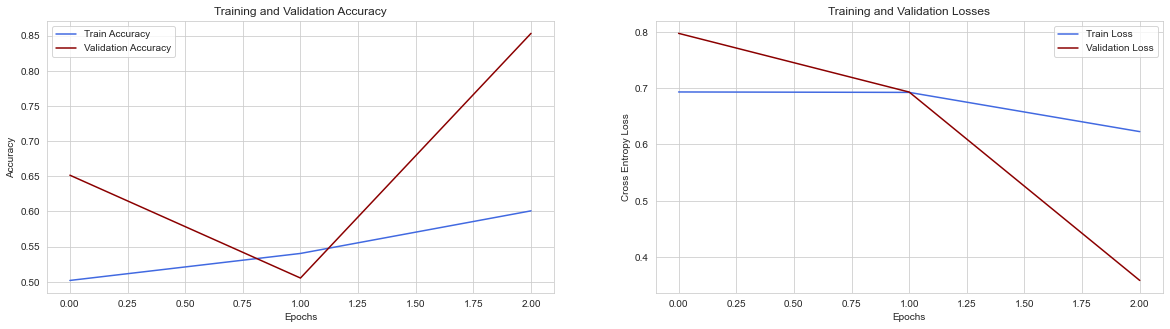

confusion_matrix : 


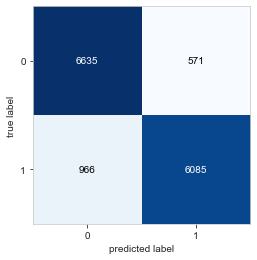

classification_report : 
              precision    recall  f1-score   support

           0       0.87      0.92      0.90      7206
           1       0.91      0.86      0.89      7051

    accuracy                           0.89     14257
   macro avg       0.89      0.89      0.89     14257
weighted avg       0.89      0.89      0.89     14257



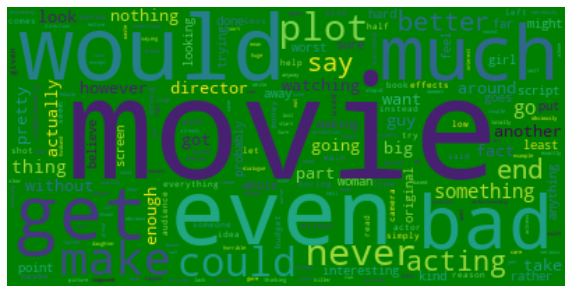

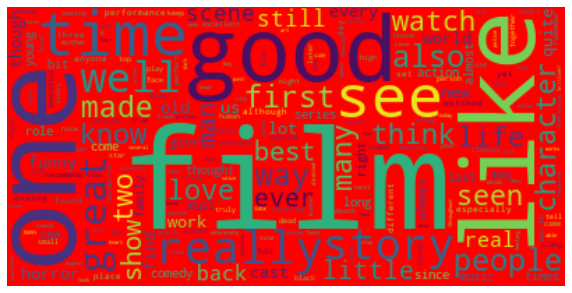

In [215]:
Net, TEXT, test_dataset = main(type_of_rnn,model_name, batch_size, embedding_dim,embedding_vector,fix_length, hidden_dim_per_layer,output_dim, dropout, criterion, LR, N_EPOCHS, is_training , Visualize_Results)

In [216]:
def prediction(model, data_loader):
    y_pred = []
    y_true = []
    model.to(device)
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for batch in data_loader:
            inputs, text_lengths = batch.review
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            predicted = predicted.cpu().detach().numpy()
                
            # append the predicted and label into list
            y_pred.append(predicted)
            
    y_pred = np.concatenate(y_pred, axis=0)
    
    if device.type == 'cuda':
        torch.cuda.empty_cache()
    return y_pred

In [217]:
test_iterator = data.BucketIterator(
    test_dataset, 
    batch_size = 2000,
    train =False,
    sort=False,
    device = device)

In [219]:
y = prediction(Net, test_iterator)

In [228]:
reviews = pd.read_csv("data/unlabeled.csv")

In [229]:
reviews.drop(['Review'], axis=1, inplace=True)

In [230]:
reviews['Sentiment'] = y.tolist()

In [231]:
reviews

ID  Sentiment
0        0          0
1        1          0
2        2          0
3        3          0
4        4          0
...    ...        ...
1995  1995          1
1996  1996          1
1997  1997          0
1998  1998          1
1999  1999          1

[2000 rows x 2 columns]

In [232]:
reviews.to_csv('msds19062_predications.csv',index=False)

Akmal Masud
Roll No : MSDS19062
Number of training examples: 26612
Number of validation examples: 6653
Number of testing examples: 14257


Train Epoch: 1 / 5:   0%|                                                                    | 0/26612 [00:00<?, ?it/s]

Initialize_Network(
  (embedding): Embedding(26928, 300, padding_idx=1)
  (rnn): ModuleList(
    (0): LSTM(
      (W_x): Linear(in_features=300, out_features=1024, bias=True)
      (W_h): Linear(in_features=256, out_features=1024, bias=True)
    )
    (1): LSTM(
      (W_x): Linear(in_features=256, out_features=512, bias=True)
      (W_h): Linear(in_features=128, out_features=512, bias=True)
    )
  )
  (drop_layer): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=128, out_features=2, bias=True)
)


Train Epoch: 1 / 5: 31200it [01:03, 493.97it/s]                                                                        
Train Loss: 0.693556 | Validation Loss: 0.692648 | Train Accuracy: 0.51 | Validation Accuracy: 0.50
Train Epoch: 2 / 5: 31200it [01:03, 494.47it/s]                                                                        
Train Loss: 0.687374 | Validation Loss: 0.693021 | Train Accuracy: 0.53 | Validation Accuracy: 0.50
Train Epoch: 3 / 5: 31200it [01:03, 491.23it/s]                                                                        
Train Loss: 0.690000 | Validation Loss: 0.647832 | Train Accuracy: 0.52 | Validation Accuracy: 0.77
Train Epoch: 4 / 5: 31200it [01:02, 497.76it/s]                                                                        
Train Loss: 0.688442 | Validation Loss: 0.688029 | Train Accuracy: 0.53 | Validation Accuracy: 0.52
Train Epoch: 5 / 5: 31200it [01:03, 493.84it/s]                                                                        


Test Loss is :  0.3303571834361979
Accuracy of the network on the 14257 test images: 86.97 %


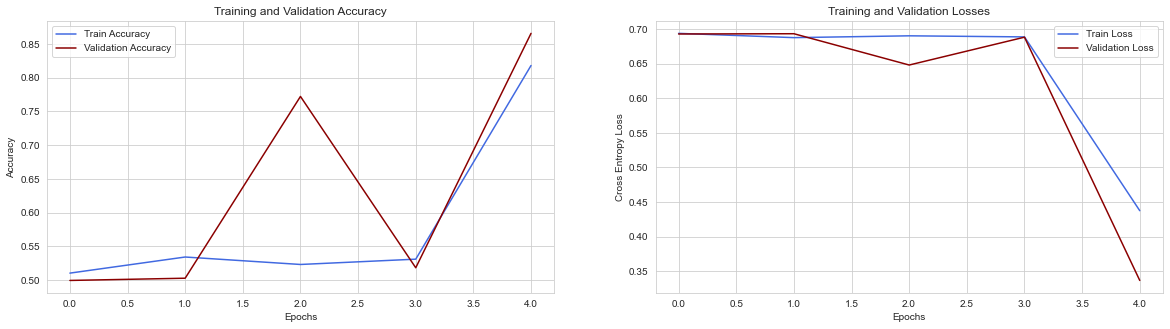

confusion_matrix : 


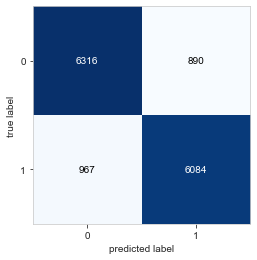

classification_report : 
              precision    recall  f1-score   support

           0       0.87      0.88      0.87      7206
           1       0.87      0.86      0.87      7051

    accuracy                           0.87     14257
   macro avg       0.87      0.87      0.87     14257
weighted avg       0.87      0.87      0.87     14257



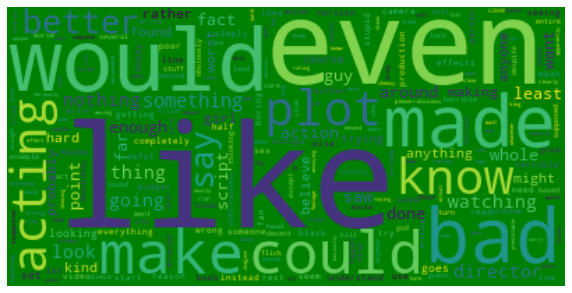

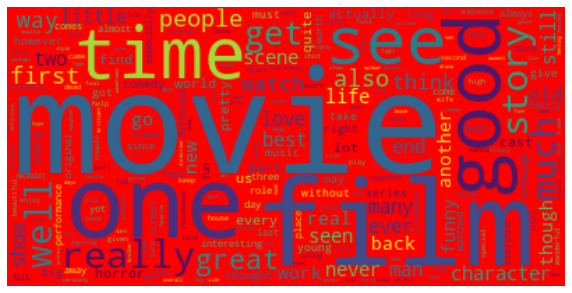

In [127]:
type_of_rnn = "LSTM"
model_name = 'LSTM.pth'
fix_length = 150
batch_size = 128
LR = 0.001
is_training = True
Visualize_Results = True
N_EPOCHS = 5
embedding_vector = '300'
embedding_dim = 300
hidden_dim_per_layer = [256,128]
output_dim = 2
dropout = 0.5
criterion = nn.CrossEntropyLoss()
main(type_of_rnn,model_name, batch_size, embedding_dim,embedding_vector,fix_length, hidden_dim_per_layer,output_dim, dropout, criterion, LR, N_EPOCHS, is_training , Visualize_Results)

Akmal Masud
Roll No : MSDS19062
Number of training examples: 26612
Number of validation examples: 6653
Number of testing examples: 14257


Train Epoch: 1 / 6:   0%|                                                                    | 0/26612 [00:00<?, ?it/s]

Initialize_Network(
  (embedding): Embedding(26928, 300, padding_idx=1)
  (rnn): ModuleList(
    (0): RNN(
      (W_x): Linear(in_features=300, out_features=256, bias=True)
      (W_h): Linear(in_features=256, out_features=256, bias=True)
    )
  )
  (drop_layer): Dropout(p=0.25, inplace=False)
  (fc): Linear(in_features=256, out_features=2, bias=True)
)


Train Epoch: 1 / 6: 31200it [00:16, 1841.23it/s]                                                                       
Train Loss: 0.703646 | Validation Loss: 0.723490 | Train Accuracy: 0.50 | Validation Accuracy: 0.50
Train Epoch: 2 / 6: 31200it [00:16, 1838.54it/s]                                                                       
Train Loss: 0.706211 | Validation Loss: 0.709208 | Train Accuracy: 0.50 | Validation Accuracy: 0.50
Train Epoch: 3 / 6: 31200it [00:16, 1844.84it/s]                                                                       
Train Loss: 0.703265 | Validation Loss: 0.693302 | Train Accuracy: 0.50 | Validation Accuracy: 0.50
Train Epoch: 4 / 6: 31200it [00:16, 1846.48it/s]                                                                       
Train Loss: 0.700788 | Validation Loss: 0.693649 | Train Accuracy: 0.50 | Validation Accuracy: 0.50
Train Epoch: 5 / 6: 31200it [00:17, 1832.38it/s]                                                                       


Test Loss is :  0.6956739713038717
Accuracy of the network on the 14257 test images: 49.46 %


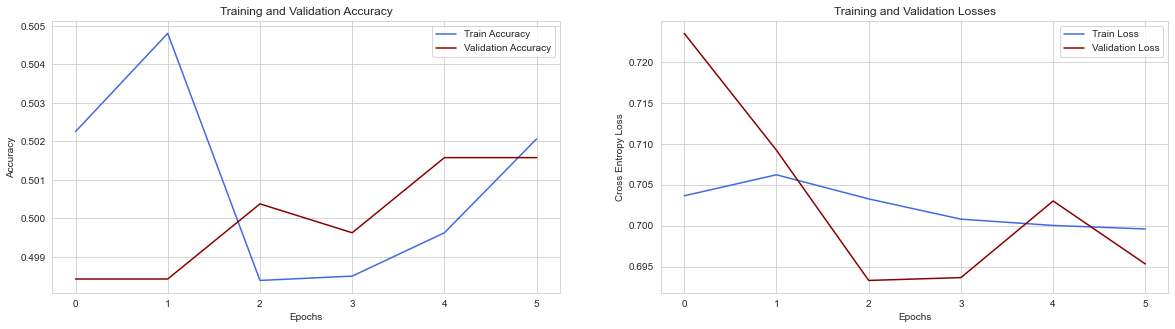

confusion_matrix : 


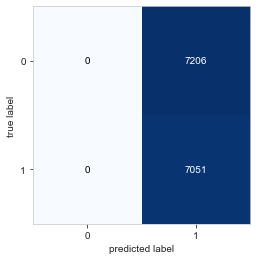

classification_report : 
              precision    recall  f1-score   support

           0       0.00      0.00      0.00      7206
           1       0.49      1.00      0.66      7051

    accuracy                           0.49     14257
   macro avg       0.25      0.50      0.33     14257
weighted avg       0.24      0.49      0.33     14257



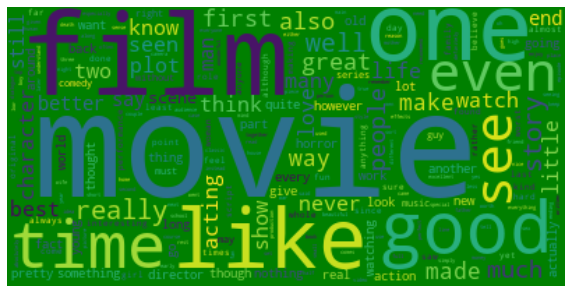

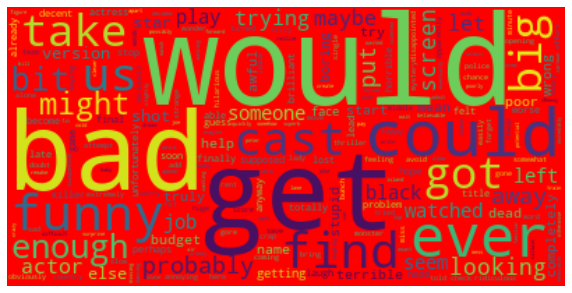

In [110]:
type_of_rnn = "Vanilla RNN"
model_name = 'RNN.pth'
fix_length = 150
batch_size = 128
LR = 0.001
is_training = True
Visualize_Results = True
N_EPOCHS = 6
embedding_vector = '300'
embedding_dim = 300
hidden_dim_per_layer = [256]
output_dim = 2
dropout = 0.25
criterion = nn.CrossEntropyLoss()
main(type_of_rnn,model_name, batch_size, embedding_dim,embedding_vector,fix_length, hidden_dim_per_layer,output_dim, dropout, criterion, LR, N_EPOCHS, is_training , Visualize_Results)

Akmal Masud
Roll No : MSDS19062
Number of training examples: 26612
Number of validation examples: 6653
Number of testing examples: 14257


Train Epoch: 1 / 6:   0%|                                                                    | 0/26612 [00:00<?, ?it/s]

Initialize_Network(
  (embedding): Embedding(26928, 100, padding_idx=1)
  (rnn): ModuleList(
    (0): RNN(
      (W_x): Linear(in_features=100, out_features=256, bias=True)
      (W_h): Linear(in_features=256, out_features=256, bias=True)
    )
  )
  (drop_layer): Dropout(p=0.25, inplace=False)
  (fc): Linear(in_features=256, out_features=2, bias=True)
)


Train Epoch: 1 / 6: 31200it [00:16, 1855.81it/s]                                                                       
Train Loss: 0.703258 | Validation Loss: 0.728506 | Train Accuracy: 0.50 | Validation Accuracy: 0.50
Train Epoch: 2 / 6: 31200it [00:16, 1867.82it/s]                                                                       
Train Loss: 0.705128 | Validation Loss: 0.710438 | Train Accuracy: 0.50 | Validation Accuracy: 0.50
Train Epoch: 3 / 6: 31200it [00:16, 1888.39it/s]                                                                       
Train Loss: 0.702680 | Validation Loss: 0.693393 | Train Accuracy: 0.50 | Validation Accuracy: 0.50
Train Epoch: 4 / 6: 31200it [00:16, 1863.24it/s]                                                                       
Train Loss: 0.700003 | Validation Loss: 0.693504 | Train Accuracy: 0.50 | Validation Accuracy: 0.50
Train Epoch: 5 / 6: 31200it [00:16, 1858.14it/s]                                                                       


Test Loss is :  0.6943541781178543
Accuracy of the network on the 14257 test images: 50.56 %


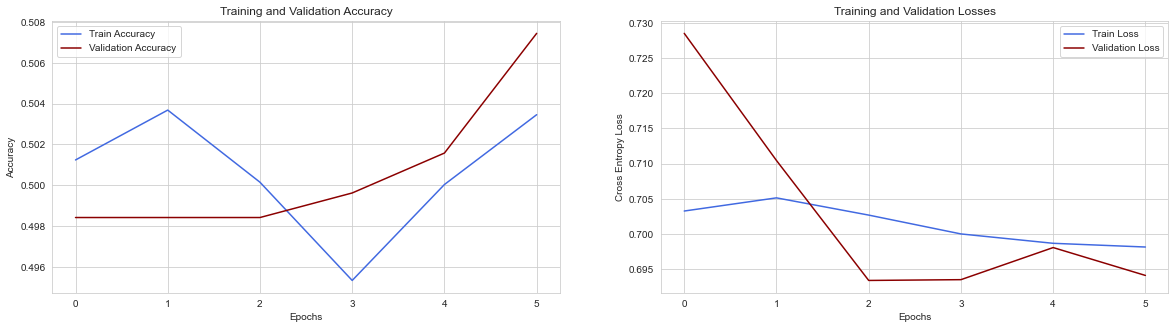

confusion_matrix : 


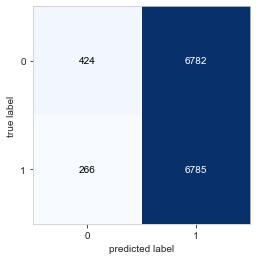

classification_report : 
              precision    recall  f1-score   support

           0       0.61      0.06      0.11      7206
           1       0.50      0.96      0.66      7051

    accuracy                           0.51     14257
   macro avg       0.56      0.51      0.38     14257
weighted avg       0.56      0.51      0.38     14257



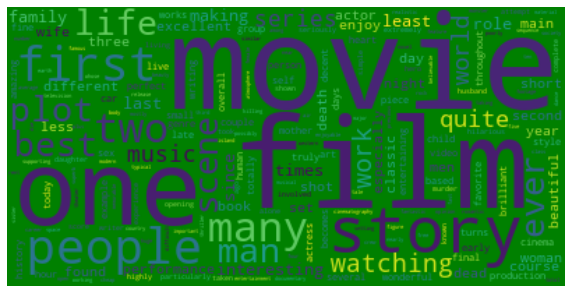

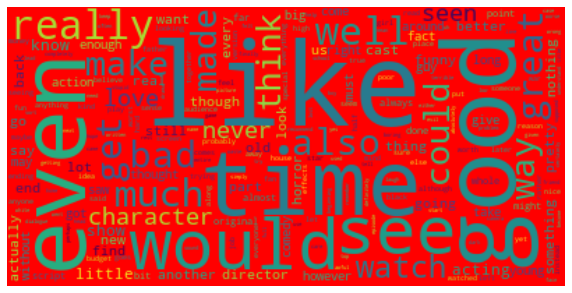

In [111]:
type_of_rnn = "Vanilla RNN"
model_name = 'RNN.pth'
fix_length = 150
batch_size = 128
LR = 0.001
is_training = True
Visualize_Results = True
N_EPOCHS = 6
embedding_vector = '100'
embedding_dim = 100
hidden_dim_per_layer = [256]
output_dim = 2
dropout = 0.25
criterion = nn.CrossEntropyLoss()
main(type_of_rnn,model_name, batch_size, embedding_dim,embedding_vector,fix_length, hidden_dim_per_layer,output_dim, dropout, criterion, LR, N_EPOCHS, is_training , Visualize_Results)

Akmal Masud
Roll No : MSDS19062
Number of training examples: 26612
Number of validation examples: 6653
Number of testing examples: 14257


Train Epoch: 1 / 6:   0%|                                                                    | 0/26612 [00:00<?, ?it/s]

Initialize_Network(
  (embedding): Embedding(26928, 100, padding_idx=1)
  (rnn): ModuleList(
    (0): LSTM(
      (W_x): Linear(in_features=100, out_features=1024, bias=True)
      (W_h): Linear(in_features=256, out_features=1024, bias=True)
    )
  )
  (drop_layer): Dropout(p=0.25, inplace=False)
  (fc): Linear(in_features=256, out_features=2, bias=True)
)


Train Epoch: 1 / 6: 31200it [00:32, 972.22it/s]                                                                        
Train Loss: 0.692242 | Validation Loss: 0.688808 | Train Accuracy: 0.50 | Validation Accuracy: 0.52
Train Epoch: 2 / 6: 31200it [00:32, 970.78it/s]                                                                        
Train Loss: 0.670636 | Validation Loss: 0.675020 | Train Accuracy: 0.56 | Validation Accuracy: 0.54
Train Epoch: 3 / 6: 31200it [00:32, 946.66it/s]                                                                        
Train Loss: 0.666865 | Validation Loss: 0.661436 | Train Accuracy: 0.55 | Validation Accuracy: 0.55
Train Epoch: 4 / 6: 31200it [00:32, 947.47it/s]                                                                        
Train Loss: 0.609543 | Validation Loss: 0.544484 | Train Accuracy: 0.64 | Validation Accuracy: 0.81
Train Epoch: 5 / 6: 31200it [00:32, 964.57it/s]                                                                        


Test Loss is :  0.4919949546456337
Accuracy of the network on the 14257 test images: 80.87 %


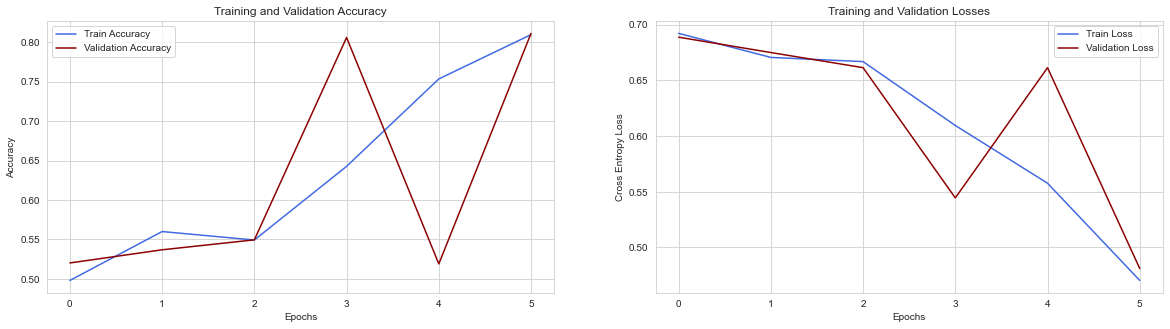

confusion_matrix : 


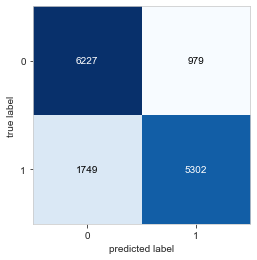

classification_report : 
              precision    recall  f1-score   support

           0       0.78      0.86      0.82      7206
           1       0.84      0.75      0.80      7051

    accuracy                           0.81     14257
   macro avg       0.81      0.81      0.81     14257
weighted avg       0.81      0.81      0.81     14257



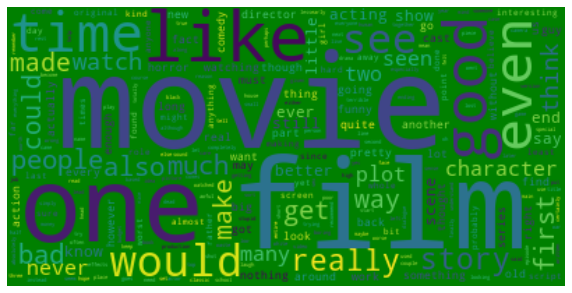

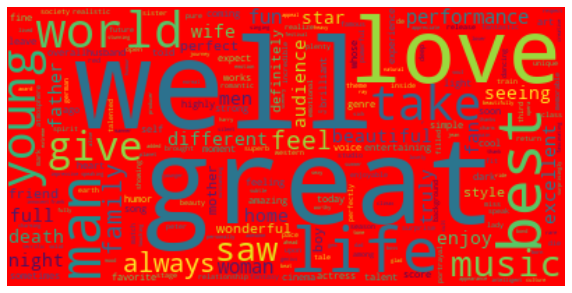

In [112]:
type_of_rnn = "LSTM"
model_name = 'LSTM.pth'
fix_length = 150
batch_size = 128
LR = 0.001
is_training = True
Visualize_Results = True
N_EPOCHS = 6
embedding_vector = '100'
embedding_dim = 100
hidden_dim_per_layer = [256]
output_dim = 2
dropout = 0.25
criterion = nn.CrossEntropyLoss()
main(type_of_rnn,model_name, batch_size, embedding_dim,embedding_vector,fix_length, hidden_dim_per_layer,output_dim, dropout, criterion, LR, N_EPOCHS, is_training , Visualize_Results)

Akmal Masud
Roll No : MSDS19062
Number of training examples: 26612
Number of validation examples: 6653
Number of testing examples: 14257


Train Epoch: 1 / 6:   0%|                                                                    | 0/26612 [00:00<?, ?it/s]

Initialize_Network(
  (embedding): Embedding(26928, 100, padding_idx=1)
  (rnn): ModuleList(
    (0): GRU(
      (W_x): Linear(in_features=100, out_features=512, bias=True)
      (U_h): Linear(in_features=256, out_features=512, bias=True)
      (W): Linear(in_features=100, out_features=256, bias=True)
      (U): Linear(in_features=256, out_features=256, bias=True)
    )
  )
  (drop_layer): Dropout(p=0.25, inplace=False)
  (fc): Linear(in_features=256, out_features=2, bias=True)
)


Train Epoch: 1 / 6: 31200it [00:46, 666.30it/s]                                                                        
Train Loss: 0.694676 | Validation Loss: 0.689754 | Train Accuracy: 0.50 | Validation Accuracy: 0.51
Train Epoch: 2 / 6: 31200it [00:46, 672.54it/s]                                                                        
Train Loss: 0.665834 | Validation Loss: 0.689799 | Train Accuracy: 0.55 | Validation Accuracy: 0.51
Train Epoch: 3 / 6: 31200it [00:46, 675.33it/s]                                                                        
Train Loss: 0.653725 | Validation Loss: 0.601861 | Train Accuracy: 0.56 | Validation Accuracy: 0.71
Train Epoch: 4 / 6: 31200it [00:45, 689.59it/s]                                                                        
Train Loss: 0.365937 | Validation Loss: 0.312052 | Train Accuracy: 0.84 | Validation Accuracy: 0.87
Train Epoch: 5 / 6: 31200it [00:45, 691.20it/s]                                                                        


Test Loss is :  0.3320974369666406
Accuracy of the network on the 14257 test images: 87.76 %


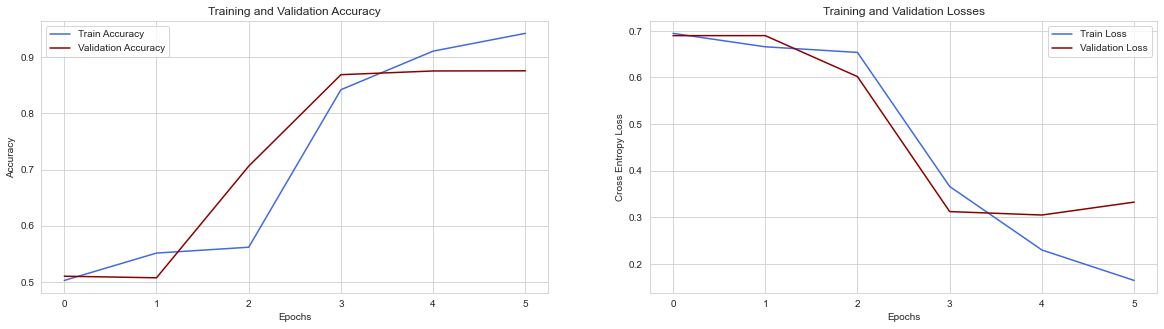

confusion_matrix : 


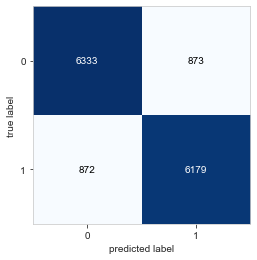

classification_report : 
              precision    recall  f1-score   support

           0       0.88      0.88      0.88      7206
           1       0.88      0.88      0.88      7051

    accuracy                           0.88     14257
   macro avg       0.88      0.88      0.88     14257
weighted avg       0.88      0.88      0.88     14257



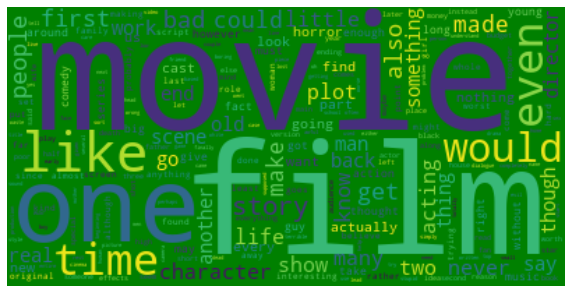

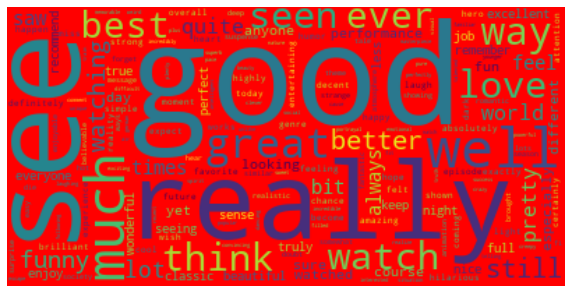

In [113]:
type_of_rnn = "GRU"
model_name = 'GRU.pth'
fix_length = 150
batch_size = 128
LR = 0.001
is_training = True
Visualize_Results = True
N_EPOCHS = 6
embedding_vector = '100'
embedding_dim = 100
hidden_dim_per_layer = [256]
output_dim = 2
dropout = 0.25
criterion = nn.CrossEntropyLoss()
main(type_of_rnn,model_name, batch_size, embedding_dim,embedding_vector,fix_length, hidden_dim_per_layer,output_dim, dropout, criterion, LR, N_EPOCHS, is_training , Visualize_Results)

Akmal Masud
Roll No : MSDS19062
Number of training examples: 26612
Number of validation examples: 6653
Number of testing examples: 14257


Train Epoch: 1 / 6:   0%|                                                                    | 0/26612 [00:00<?, ?it/s]

Initialize_Network(
  (embedding): Embedding(26928, 100, padding_idx=1)
  (rnn): ModuleList(
    (0): GRU(
      (W_x): Linear(in_features=100, out_features=512, bias=True)
      (U_h): Linear(in_features=256, out_features=512, bias=True)
      (W): Linear(in_features=100, out_features=256, bias=True)
      (U): Linear(in_features=256, out_features=256, bias=True)
    )
  )
  (drop_layer): Dropout(p=0.25, inplace=False)
  (fc): Linear(in_features=256, out_features=2, bias=True)
)


Train Epoch: 1 / 6: 31200it [00:46, 673.56it/s]                                                                        
Train Loss: 0.695424 | Validation Loss: 0.694620 | Train Accuracy: 0.50 | Validation Accuracy: 0.50
Train Epoch: 2 / 6: 31200it [00:53, 588.61it/s]                                                                        
Train Loss: 0.694156 | Validation Loss: 0.693872 | Train Accuracy: 0.50 | Validation Accuracy: 0.50
Train Epoch: 3 / 6: 31200it [00:51, 603.81it/s]                                                                        
Train Loss: 0.694129 | Validation Loss: 0.693507 | Train Accuracy: 0.50 | Validation Accuracy: 0.50
Train Epoch: 4 / 6: 31200it [00:46, 669.20it/s]                                                                        
Train Loss: 0.693818 | Validation Loss: 0.693326 | Train Accuracy: 0.50 | Validation Accuracy: 0.50
Train Epoch: 5 / 6: 31200it [00:47, 662.59it/s]                                                                        


Test Loss is :  0.692997869104147
Accuracy of the network on the 14257 test images: 50.58 %


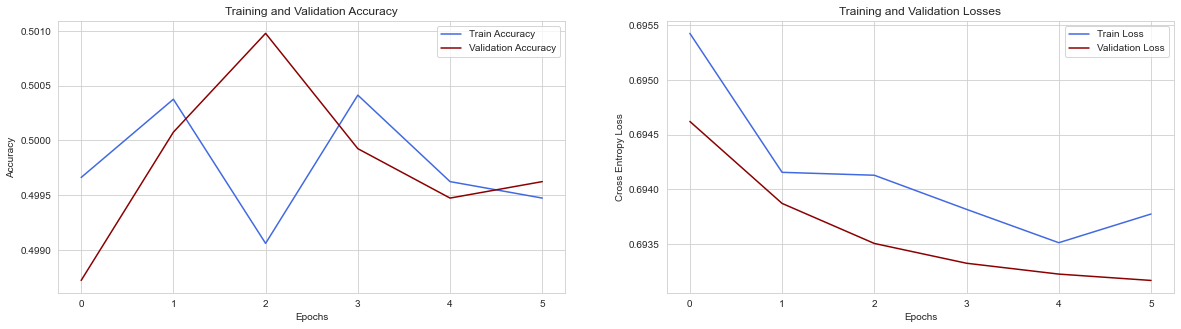

confusion_matrix : 


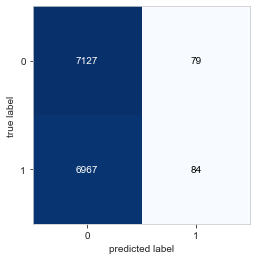

classification_report : 
              precision    recall  f1-score   support

           0       0.51      0.99      0.67      7206
           1       0.52      0.01      0.02      7051

    accuracy                           0.51     14257
   macro avg       0.51      0.50      0.35     14257
weighted avg       0.51      0.51      0.35     14257



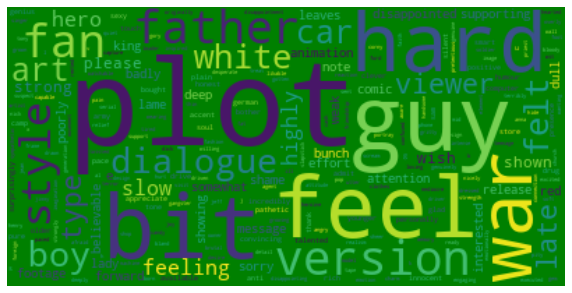

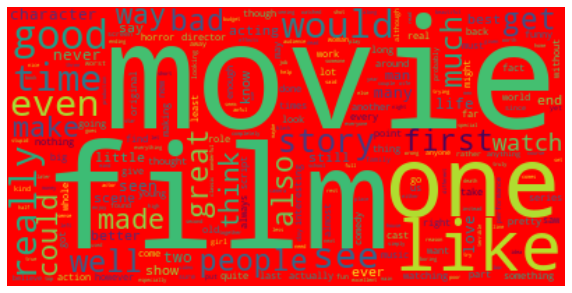

In [115]:
type_of_rnn = "GRU"
model_name = 'GRU.pth'
fix_length = 150
batch_size = 128
LR = 0.001
is_training = True
Visualize_Results = True
N_EPOCHS = 6
embedding_vector = '100'
embedding_dim = 100
hidden_dim_per_layer = [256]
output_dim = 2
dropout = 0.25
criterion = nn.CrossEntropyLoss()
main(type_of_rnn,model_name, batch_size, embedding_dim,embedding_vector,fix_length, hidden_dim_per_layer,output_dim, dropout, criterion, LR, N_EPOCHS, is_training , Visualize_Results)

Akmal Masud
Roll No : MSDS19062
Number of training examples: 26612
Number of validation examples: 6653
Number of testing examples: 14257


Train Epoch: 1 / 6:   0%|                                                                    | 0/26612 [00:00<?, ?it/s]

Initialize_Network(
  (embedding): Embedding(26928, 100, padding_idx=1)
  (rnn): ModuleList(
    (0): LSTM(
      (W_x): Linear(in_features=100, out_features=1024, bias=True)
      (W_h): Linear(in_features=256, out_features=1024, bias=True)
    )
  )
  (drop_layer): Dropout(p=0.25, inplace=False)
  (fc): Linear(in_features=256, out_features=2, bias=True)
)


Train Epoch: 1 / 6: 31200it [00:33, 932.21it/s]                                                                        
Train Loss: 0.693858 | Validation Loss: 0.693288 | Train Accuracy: 0.50 | Validation Accuracy: 0.50
Train Epoch: 2 / 6: 31200it [00:33, 931.69it/s]                                                                        
Train Loss: 0.693451 | Validation Loss: 0.693194 | Train Accuracy: 0.50 | Validation Accuracy: 0.50
Train Epoch: 3 / 6: 31200it [00:34, 903.84it/s]                                                                        
Train Loss: 0.693324 | Validation Loss: 0.693129 | Train Accuracy: 0.50 | Validation Accuracy: 0.50
Train Epoch: 4 / 6: 31200it [00:33, 928.02it/s]                                                                        
Train Loss: 0.693294 | Validation Loss: 0.693085 | Train Accuracy: 0.50 | Validation Accuracy: 0.50
Train Epoch: 5 / 6: 31200it [00:32, 969.18it/s]                                                                        


Test Loss is :  0.6932118173156466
Accuracy of the network on the 14257 test images: 49.96 %


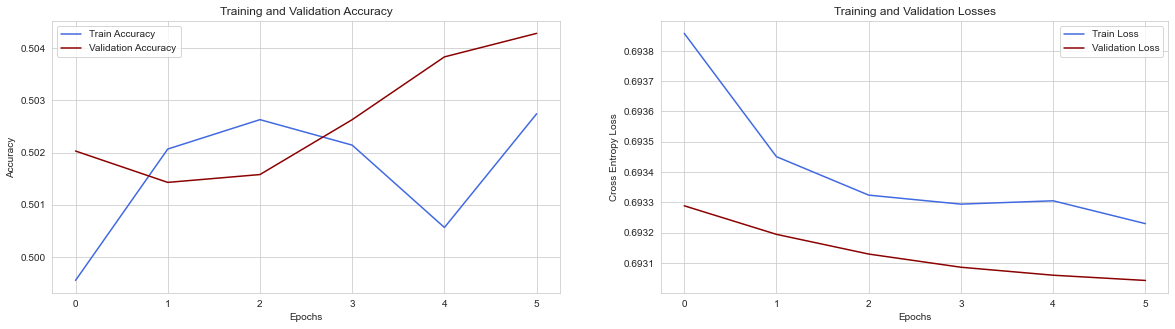

confusion_matrix : 


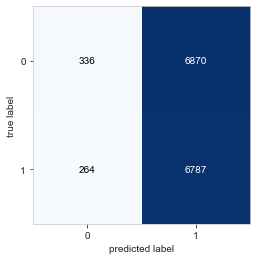

classification_report : 
              precision    recall  f1-score   support

           0       0.56      0.05      0.09      7206
           1       0.50      0.96      0.66      7051

    accuracy                           0.50     14257
   macro avg       0.53      0.50      0.37     14257
weighted avg       0.53      0.50      0.37     14257



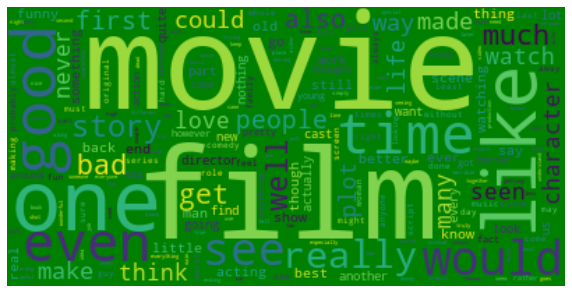

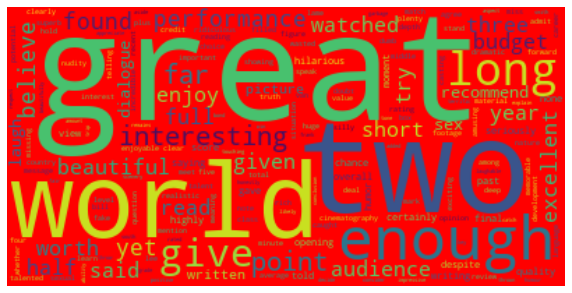

In [116]:
type_of_rnn = "LSTM"
model_name = 'LSTM.pth'
fix_length = 150
batch_size = 128
LR = 0.001
is_training = True
Visualize_Results = True
N_EPOCHS = 6
embedding_vector = '100'
embedding_dim = 100
hidden_dim_per_layer = [256]
output_dim = 2
dropout = 0.25
criterion = nn.CrossEntropyLoss()
main(type_of_rnn,model_name, batch_size, embedding_dim,embedding_vector,fix_length, hidden_dim_per_layer,output_dim, dropout, criterion, LR, N_EPOCHS, is_training , Visualize_Results)

Akmal Masud
Roll No : MSDS19062
Number of training examples: 26612
Number of validation examples: 6653
Number of testing examples: 14257


Train Epoch: 1 / 6:   1%|▎                                                        | 150/26612 [00:00<00:29, 900.43it/s]

Initialize_Network(
  (embedding): Embedding(26928, 100, padding_idx=1)
  (rnn): ModuleList(
    (0): RNN(
      (W_x): Linear(in_features=100, out_features=256, bias=True)
      (W_h): Linear(in_features=256, out_features=256, bias=True)
    )
  )
  (drop_layer): Dropout(p=0.25, inplace=False)
  (fc): Linear(in_features=256, out_features=2, bias=True)
)


Train Epoch: 1 / 6: 31200it [00:17, 1831.78it/s]                                                                       
Train Loss: 0.696817 | Validation Loss: 0.694142 | Train Accuracy: 0.50 | Validation Accuracy: 0.50
Train Epoch: 2 / 6: 31200it [00:17, 1812.27it/s]                                                                       
Train Loss: 0.694175 | Validation Loss: 0.693238 | Train Accuracy: 0.50 | Validation Accuracy: 0.50
Train Epoch: 3 / 6: 31200it [00:17, 1807.69it/s]                                                                       
Train Loss: 0.694156 | Validation Loss: 0.693098 | Train Accuracy: 0.50 | Validation Accuracy: 0.50
Train Epoch: 4 / 6: 31200it [00:16, 1841.14it/s]                                                                       
Train Loss: 0.694129 | Validation Loss: 0.693037 | Train Accuracy: 0.50 | Validation Accuracy: 0.50
Train Epoch: 5 / 6: 31200it [00:17, 1827.45it/s]                                                                       


Test Loss is :  0.6926409495728356
Accuracy of the network on the 14257 test images: 50.30 %


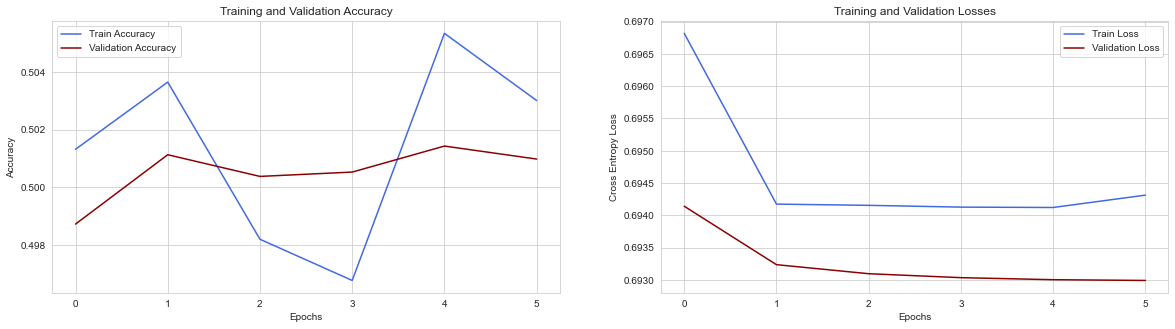

confusion_matrix : 


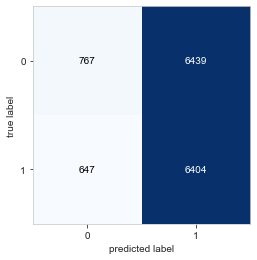

classification_report : 
              precision    recall  f1-score   support

           0       0.54      0.11      0.18      7206
           1       0.50      0.91      0.64      7051

    accuracy                           0.50     14257
   macro avg       0.52      0.51      0.41     14257
weighted avg       0.52      0.50      0.41     14257



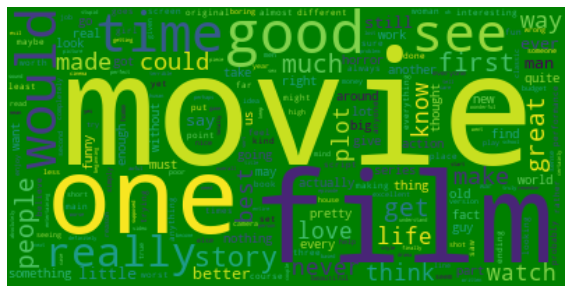

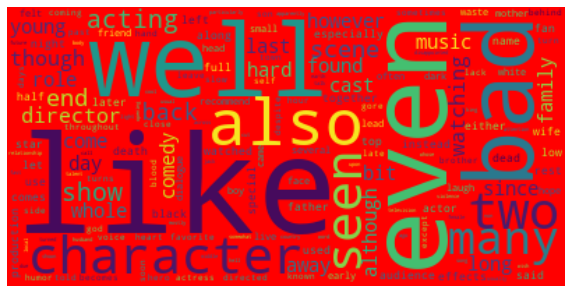

In [117]:
type_of_rnn = "Vanilla RNN"
model_name = 'RNN.pth'
fix_length = 150
batch_size = 128
LR = 0.001
is_training = True
Visualize_Results = True
N_EPOCHS = 6
embedding_vector = '100'
embedding_dim = 100
hidden_dim_per_layer = [256]
output_dim = 2
dropout = 0.25
criterion = nn.CrossEntropyLoss()
main(type_of_rnn,model_name, batch_size, embedding_dim,embedding_vector,fix_length, hidden_dim_per_layer,output_dim, dropout, criterion, LR, N_EPOCHS, is_training , Visualize_Results)